<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer

import sys
from pathlib import Path
PROJ = Path.cwd() / "tDuqfl_Project"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tDuQFL_Project"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive/Teleportation/tDuQFL_Project/"

In [4]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tDuQFL_Project"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))


In [5]:
from common.imports import *
from configs.dataset_genome_iid import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True


Load and Split data

In [6]:
from data.preprocess_genome import load_and_prepare_dataset
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch, split_type,
    global_seed
)

np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")

In [7]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.100000, PERT_used=0.100000 → LR_next=0.100618, PERT_next=0.101235
Training Accuracy: 0.72
Test Accuracy: 0.60


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.100618, PERT_used=0.101235 → LR_next=0.101934, PERT_next=0.103867
Training Accuracy: 0.70
Test Accuracy: 0.57


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.101934, PERT_used=0.103867 → LR_next=0.103213, PERT_next=0.106427
Training Accuracy: 0.68
Test Accuracy: 0.59


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.103213, PERT_used=0.106427 → LR_next=0.104254, PERT_next=0.108508
Training Accuracy: 0.66
Test Accuracy: 0.54


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.104254, PERT_used=0.108508 → LR_next=0.105189, PERT_next=0.110378
Training Accuracy: 0.68
Test Accuracy: 0.54


Deep Unfolding Iteration 1/5
[client 1 | unfold 1] LR_used=0.100000, PERT_used=0.100000 → LR_next=0.10056

Training Progress:  10%|█         | 1/10 [15:59<2:23:55, 959.45s/it]

[Round   0] acc_g=0.792 (μ=0.584, σ=0.122, FG=0.240) | t=942.167s, val=0.608 | TEL=FALSE
[Round 1] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.105189, PERT_used=0.110378 → LR_next=0.105677, PERT_next=0.111354
Training Accuracy: 0.38
Test Accuracy: 0.35


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.105677, PERT_used=0.111354 → LR_next=0.106688, PERT_next=0.113376
Training Accuracy: 0.40
Test Accuracy: 0.36


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.106688, PERT_used=0.113376 → LR_next=0.107810, PERT_next=0.115621
Training Accuracy: 0.42
Test Accuracy: 0.40


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.107810, PERT_used=0.115621 → LR_next=0.108948, PERT_next=0.117897
Training Accuracy: 0.48
Test Accuracy: 0.42


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.108948, PERT_used=0.117897 → LR_next=0.110248, PERT_next=0.120496
Training Accuracy: 0.48
Test Accuracy: 0.41


Deep Unfolding I

Training Progress:  20%|██        | 2/10 [31:01<2:03:27, 925.94s/it]

[Round   1] acc_g=0.743 (μ=0.619, σ=0.125, FG=0.268) | t=884.781s, val=0.639 | TEL=FALSE
[Round 2] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.110248, PERT_used=0.120496 → LR_next=0.111127, PERT_next=0.122253
Training Accuracy: 0.76
Test Accuracy: 0.60


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.111127, PERT_used=0.122253 → LR_next=0.112597, PERT_next=0.125193
Training Accuracy: 0.78
Test Accuracy: 0.67


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.112597, PERT_used=0.125193 → LR_next=0.114148, PERT_next=0.128296
Training Accuracy: 0.74
Test Accuracy: 0.67


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.114148, PERT_used=0.128296 → LR_next=0.115736, PERT_next=0.131472
Training Accuracy: 0.84
Test Accuracy: 0.69


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.115736, PERT_used=0.131472 → LR_next=0.117085, PERT_next=0.134171
Training Accuracy: 0.84
Test Accuracy: 0.69


Deep Unfolding I

Training Progress:  30%|███       | 3/10 [45:32<1:45:06, 900.87s/it]

[Round   2] acc_g=0.755 (μ=0.708, σ=0.032, FG=0.059) | t=854.468s, val=0.548 | TEL=FALSE
[Round 3] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.117085, PERT_used=0.134171 → LR_next=0.117809, PERT_next=0.135617
Training Accuracy: 0.66
Test Accuracy: 0.63


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.117809, PERT_used=0.135617 → LR_next=0.119035, PERT_next=0.138070
Training Accuracy: 0.72
Test Accuracy: 0.66


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.119035, PERT_used=0.138070 → LR_next=0.120265, PERT_next=0.140529
Training Accuracy: 0.76
Test Accuracy: 0.68


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.120265, PERT_used=0.140529 → LR_next=0.121477, PERT_next=0.142954
Training Accuracy: 0.76
Test Accuracy: 0.66


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.121477, PERT_used=0.142954 → LR_next=0.122686, PERT_next=0.145373
Training Accuracy: 0.64
Test Accuracy: 0.62


Deep Unfolding I

Training Progress:  40%|████      | 4/10 [1:00:34<1:30:06, 901.13s/it]

[Round   3] acc_g=0.711 (μ=0.634, σ=0.091, FG=0.186) | t=883.736s, val=0.588 | TEL=FALSE
[Round 4] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.122686, PERT_used=0.145373 → LR_next=0.123863, PERT_next=0.147727
Training Accuracy: 0.46
Test Accuracy: 0.65


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.123863, PERT_used=0.147727 → LR_next=0.125938, PERT_next=0.151876
Training Accuracy: 0.58
Test Accuracy: 0.75


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.125938, PERT_used=0.151876 → LR_next=0.128388, PERT_next=0.156775
Training Accuracy: 0.76
Test Accuracy: 0.79


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.128388, PERT_used=0.156775 → LR_next=0.130658, PERT_next=0.161315
Training Accuracy: 0.86
Test Accuracy: 0.74


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.130658, PERT_used=0.161315 → LR_next=0.132319, PERT_next=0.164637
Training Accuracy: 0.86
Test Accuracy: 0.76


Deep Unfolding I

Training Progress:  50%|█████     | 5/10 [1:15:37<1:15:08, 901.72s/it]

[Round   4] acc_g=0.805 (μ=0.713, σ=0.073, FG=0.142) | t=886.105s, val=0.551 | TEL=FALSE
[Round 5] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.132319, PERT_used=0.164637 → LR_next=0.132796, PERT_next=0.165591
Training Accuracy: 0.54
Test Accuracy: 0.57


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.132796, PERT_used=0.165591 → LR_next=0.133998, PERT_next=0.167997
Training Accuracy: 0.68
Test Accuracy: 0.71


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.133998, PERT_used=0.167997 → LR_next=0.135440, PERT_next=0.170881
Training Accuracy: 0.80
Test Accuracy: 0.78


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.135440, PERT_used=0.170881 → LR_next=0.136818, PERT_next=0.173637
Training Accuracy: 0.78
Test Accuracy: 0.78


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.136818, PERT_used=0.173637 → LR_next=0.138030, PERT_next=0.176061
Training Accuracy: 0.86
Test Accuracy: 0.81


Deep Unfolding I

Training Progress:  60%|██████    | 6/10 [1:30:04<59:20, 890.02s/it]  

[Round   5] acc_g=0.823 (μ=0.734, σ=0.097, FG=0.219) | t=851.144s, val=0.554 | TEL=FALSE
[Round 6] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.138030, PERT_used=0.176061 → LR_next=0.139307, PERT_next=0.178613
Training Accuracy: 0.52
Test Accuracy: 0.61


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.139307, PERT_used=0.178613 → LR_next=0.141237, PERT_next=0.182473
Training Accuracy: 0.66
Test Accuracy: 0.65


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.141237, PERT_used=0.182473 → LR_next=0.143228, PERT_next=0.186456
Training Accuracy: 0.82
Test Accuracy: 0.64


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.143228, PERT_used=0.186456 → LR_next=0.145016, PERT_next=0.190033
Training Accuracy: 0.82
Test Accuracy: 0.67


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.145016, PERT_used=0.190033 → LR_next=0.146459, PERT_next=0.192919
Training Accuracy: 0.78
Test Accuracy: 0.66


Deep Unfolding I

Training Progress:  70%|███████   | 7/10 [1:44:23<43:59, 879.71s/it]

[Round   6] acc_g=0.787 (μ=0.634, σ=0.124, FG=0.279) | t=842.349s, val=0.536 | TEL=FALSE
[Round 7] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.146459, PERT_used=0.192919 → LR_next=0.147566, PERT_next=0.195133
Training Accuracy: 0.76
Test Accuracy: 0.84


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.147566, PERT_used=0.195133 → LR_next=0.149812, PERT_next=0.199624
Training Accuracy: 0.86
Test Accuracy: 0.89


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.149812, PERT_used=0.199624 → LR_next=0.152008, PERT_next=0.204016
Training Accuracy: 0.86
Test Accuracy: 0.89


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.152008, PERT_used=0.204016 → LR_next=0.154099, PERT_next=0.208198
Training Accuracy: 0.86
Test Accuracy: 0.88


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.154099, PERT_used=0.208198 → LR_next=0.155741, PERT_next=0.211482
Training Accuracy: 0.88
Test Accuracy: 0.87


Deep Unfolding I

Training Progress:  80%|████████  | 8/10 [1:58:46<29:09, 874.58s/it]

[Round   7] acc_g=0.874 (μ=0.734, σ=0.120, FG=0.253) | t=847.118s, val=0.502 | TEL=FALSE
[Round 8] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.155741, PERT_used=0.211482 → LR_next=0.156678, PERT_next=0.213355
Training Accuracy: 0.60
Test Accuracy: 0.57


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.156678, PERT_used=0.213355 → LR_next=0.158753, PERT_next=0.217506
Training Accuracy: 0.80
Test Accuracy: 0.68


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.158753, PERT_used=0.217506 → LR_next=0.160674, PERT_next=0.221349
Training Accuracy: 0.86
Test Accuracy: 0.74


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.160674, PERT_used=0.221349 → LR_next=0.162485, PERT_next=0.224970
Training Accuracy: 0.86
Test Accuracy: 0.77


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.162485, PERT_used=0.224970 → LR_next=0.164230, PERT_next=0.228460
Training Accuracy: 0.82
Test Accuracy: 0.78


Deep Unfolding I

Training Progress:  90%|█████████ | 9/10 [2:13:07<14:30, 870.17s/it]

[Round   8] acc_g=0.891 (μ=0.696, σ=0.129, FG=0.284) | t=844.310s, val=0.534 | TEL=FALSE
[Round 9] Teleportation OFF


Deep Unfolding Iteration 1/5
[client 0 | unfold 1] LR_used=0.164230, PERT_used=0.228460 → LR_next=0.165609, PERT_next=0.231218
Training Accuracy: 0.64
Test Accuracy: 0.62


Deep Unfolding Iteration 2/5
[client 0 | unfold 2] LR_used=0.165609, PERT_used=0.231218 → LR_next=0.168366, PERT_next=0.236732
Training Accuracy: 0.64
Test Accuracy: 0.57


Deep Unfolding Iteration 3/5
[client 0 | unfold 3] LR_used=0.168366, PERT_used=0.236732 → LR_next=0.170739, PERT_next=0.241478
Training Accuracy: 0.74
Test Accuracy: 0.60


Deep Unfolding Iteration 4/5
[client 0 | unfold 4] LR_used=0.170739, PERT_used=0.241478 → LR_next=0.172798, PERT_next=0.245595
Training Accuracy: 0.74
Test Accuracy: 0.60


Deep Unfolding Iteration 5/5
[client 0 | unfold 5] LR_used=0.172798, PERT_used=0.245595 → LR_next=0.174322, PERT_next=0.248643
Training Accuracy: 0.74
Test Accuracy: 0.60


Deep Unfolding I

Training Progress: 100%|██████████| 10/10 [2:27:27<00:00, 884.72s/it]

[Round   9] acc_g=0.909 (μ=0.781, σ=0.106, FG=0.225) | t=843.130s, val=0.568 | TEL=FALSE


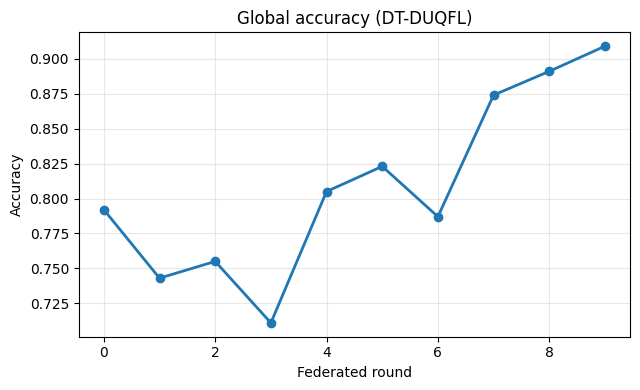

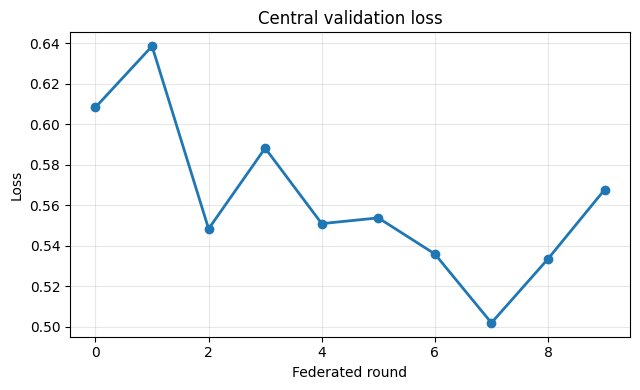

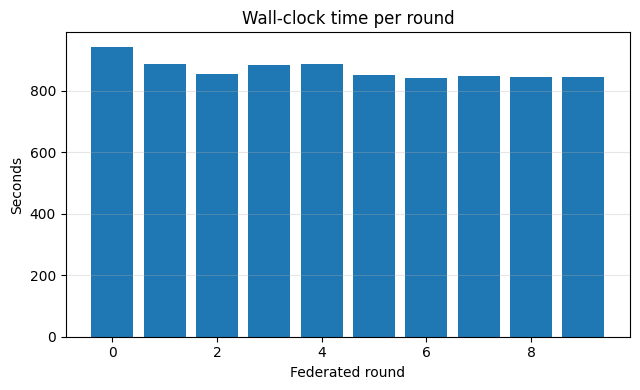

In [8]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink_v3.csv")
)

global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
